In [1]:
import sys
sys.path.append("../code")
import pandas as pd
import random
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import blotto_utils as bu

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# 538 Data

In [5]:
weights = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

data_dir = '/Users/Alex/Documents/Alex/Yale/Fall 2019/CPSC_490/blotto/data/'

fivethirtyeight_data_dir = data_dir + 'fivethirtyeight/'

data_files = sorted(glob(fivethirtyeight_data_dir + '*'))
train_list = []
test_list = []
for i in range(len(data_files)):
    print(i)
    temp_df = pd.read_csv(data_files[i])
    new_column_names = list(map((lambda x : '_'.join(x.split(' ')).lower()), list(temp_df.columns)))
    new_column_names[-1] = 'reason'

    temp_df.rename(dict(zip(list(temp_df.columns), new_column_names)), axis=1, inplace=True)

    temp_df['total_troops'] = temp_df['castle_1'] + \
                              temp_df['castle_2'] + \
                              temp_df['castle_3'] + \
                              temp_df['castle_4'] + \
                              temp_df['castle_5'] + \
                              temp_df['castle_6'] + \
                              temp_df['castle_7'] + \
                              temp_df['castle_8'] + \
                              temp_df['castle_9'] + \
                              temp_df['castle_10']

    full_strats_df = temp_df[temp_df.total_troops == 100].copy()
    full_strats_list = full_strats_df.to_dict('records')
    if i == 1:
        train_list += [[int(x[1]) for x in list(y.items())[:10]] for y in full_strats_list]
    else:
        test_list += [[int(x[1]) for x in list(y.items())[:10]] for y in full_strats_list]

0
1
2


## Divide into two players

In [6]:
random.seed(0)

In [9]:
a_strat_init = random.sample(train_list, 100)
b_strat_init = random.sample(train_list, 100)

In [10]:
len(a_strat_init), len(b_strat_init)

(100, 100)

# Co-Evolving Algorithm

# Entire GA

In [11]:
random.seed(0)

## Iterative Generations

In [12]:
temp_noise = bu.generate_noise_arrays(1)

In [13]:
def evolve(a_strats, b_strats, generations, noise):
    for _ in range(generations):
        a_results, b_results = bu.eval_strats(a_strats, b_strats, weights)

        a_fittest = sorted(a_results, key=(lambda x: (x[1], -(x[0][-1]))), reverse=True)
        b_fittest = sorted(b_results, key=(lambda x: (x[1], -(x[0][-1]))), reverse=True)

        a_next_gen = []
        b_next_gen = []
        for i in range(14):
            for j in range(i+1, 15):
                a_next_gen.append(bu.mutate_noise(bu.make_integer(bu.cross([a_fittest[i][0], a_fittest[j][0]]), seed=(i+j+i*j)), temp_noise, seed=(i+j)))
                b_next_gen.append(bu.mutate_noise(bu.make_integer(bu.cross([b_fittest[i][0], b_fittest[j][0]]), seed=(i+j+i*j)), temp_noise, seed=(i+j)))

        a_strats = a_next_gen
        b_strats = b_next_gen
        
    return a_fittest, b_fittest, a_strats, b_strats

In [15]:
a_strat_init = random.sample(train_list, 100)
b_strat_init = random.sample(train_list, 100)

a_strats = a_strat_init
b_strats = b_strat_init

In [16]:
temp_a_strats, temp_b_strats = a_strats, b_strats

In [17]:
best_a, best_b = [], []

In [18]:
for i in range(50):
#     print(i)
    temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(temp_a_strats, temp_b_strats, 10, temp_noise)
    best_a.append(temp_a_fittest[0][0])
    best_b.append(temp_b_fittest[0][0])
#     print('\n'.join(map(str,temp_a_fittest[:5])))

In [19]:
len(best_a), len(best_b)

(50, 50)

In [20]:
def l1_norm(a, b):
    return sum(map(abs, [x-y for x, y in zip(a, b)]))

In [21]:
import math

In [22]:
def l2_norm(a, b):
    return math.sqrt(sum([(x-y) ** 2 for x, y in zip(a, b)]))

In [23]:
best_dist_a = {}
for j in range(len(best_a)):
    best_dist_a[j] = []
    for i in range(len(best_a)):
        best_dist_a[j].append(l1_norm(best_a[j], best_a[i]))

In [24]:
best_dist_2_a = {}
for j in range(len(best_a)):
    best_dist_2_a[j] = []
    for i in range(len(best_a)):
        best_dist_2_a[j].append(l2_norm(best_a[j], best_a[i]))

In [25]:
index = 85
plt.figure(figsize=(20,10))
plt.bar(range(len(best_dist_a[index])), best_dist_a[index], 0.5, align='center')
plt.show()

KeyError: 85

<Figure size 1440x720 with 0 Axes>

In [26]:
index, jndex = 0, 85
plt.figure(figsize=(20,10))
plt.bar(range(len(best_dist_a[index])), [x-y for x,y in zip(best_dist_a[index], best_dist_a[jndex])], 0.5, align='center')
plt.show()

KeyError: 85

<Figure size 1440x720 with 0 Axes>

In [27]:
print(best_a[0])
print(best_a[85])

[3, 2, 7, 5, 12, 0, 12, 21, 36, 2]


IndexError: list index out of range

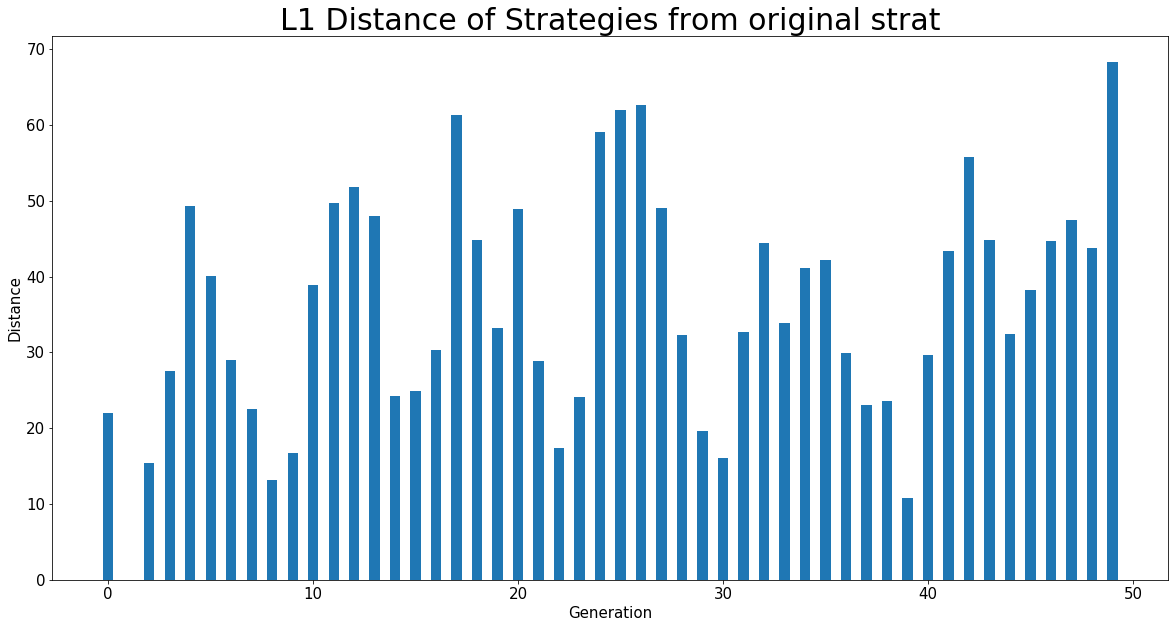

In [33]:
index = 1
plt.figure(figsize=(20,10))
plt.bar(range(len(best_dist_2_a[index])), best_dist_2_a[index], 0.5, align='center')
plt.title('L1 Distance of Strategies from original strat', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Distance", fontsize=15)
plt.xlabel("Generation", fontsize=15)
# plt.show()
plt.savefig("../figures/l1-cycle-ga.jpg")

In [97]:
temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(a_strats, b_strats, 50, temp_noise)

In [98]:
temp_a_fittest[:5]

[([0, 4, 1, 3, 14, 1, 2, 2, 38, 35], 82),
 ([0, 3, 1, 2, 14, 0, 3, 2, 39, 36], 81),
 ([0, 2, 2, 3, 15, 0, 2, 2, 38, 36], 75),
 ([0, 4, 1, 4, 15, 0, 2, 1, 38, 35], 74),
 ([0, 4, 2, 2, 15, 0, 2, 0, 39, 36], 69)]

In [99]:
temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(temp_a_strats, temp_b_strats, 50, temp_noise)

In [100]:
temp_a_fittest[:5]

[([0, 0, 0, 2, 6, 2, 4, 4, 1, 81], 99),
 ([0, 1, 0, 1, 5, 2, 4, 5, 1, 81], 94),
 ([0, 0, 1, 1, 5, 2, 5, 4, 1, 81], 93),
 ([0, 1, 0, 0, 5, 2, 6, 3, 2, 81], 91),
 ([0, 0, 1, 2, 6, 1, 6, 3, 0, 81], 87)]

In [101]:
temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(temp_a_strats, temp_b_strats, 50, temp_noise)

temp_a_fittest[:5]

[([0, 0, 2, 2, 4, 2, 1, 7, 37, 45], 104),
 ([0, 0, 2, 1, 4, 2, 1, 6, 38, 46], 102),
 ([0, 0, 4, 0, 5, 1, 4, 7, 35, 44], 101),
 ([0, 0, 3, 1, 5, 1, 3, 7, 36, 44], 101),
 ([0, 0, 1, 2, 4, 2, 2, 7, 36, 46], 100)]

In [102]:
temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(temp_a_strats, temp_b_strats, 50, temp_noise)

temp_a_fittest[:5]

[([0, 4, 9, 3, 7, 8, 13, 19, 17, 20], 100),
 ([0, 2, 11, 3, 8, 10, 12, 19, 17, 18], 96),
 ([0, 3, 10, 3, 7, 9, 13, 18, 17, 20], 91),
 ([0, 3, 9, 3, 8, 11, 11, 19, 16, 20], 91),
 ([0, 3, 10, 3, 8, 11, 11, 18, 15, 21], 91)]

In [103]:
temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(temp_a_strats, temp_b_strats, 50, temp_noise)

temp_a_fittest[:5]

[([0, 0, 8, 2, 1, 1, 7, 75, 6, 0], 101),
 ([0, 1, 9, 2, 1, 2, 5, 75, 5, 0], 101),
 ([0, 1, 9, 1, 3, 2, 5, 76, 3, 0], 101),
 ([0, 0, 9, 1, 1, 2, 5, 76, 6, 0], 100),
 ([0, 1, 8, 1, 1, 2, 5, 75, 6, 1], 99)]

In [104]:
temp_a_fittest, temp_b_fittest, temp_a_strats, temp_b_strats = evolve(temp_a_strats, temp_b_strats, 50, temp_noise)

temp_a_fittest[:5]

[([0, 0, 2, 2, 2, 4, 17, 15, 16, 42], 104),
 ([0, 0, 3, 1, 2, 3, 18, 15, 15, 43], 102),
 ([1, 0, 0, 2, 1, 3, 18, 15, 16, 44], 102),
 ([0, 0, 1, 1, 3, 4, 18, 16, 14, 43], 101),
 ([0, 0, 1, 2, 1, 4, 17, 17, 16, 42], 100)]

### 200 generations

In [33]:
a_fittest[:5]

[([0, 2, 6, 4, 9, 0, 8, 6, 64, 1], 71),
 ([1, 2, 4, 5, 2, 6, 10, 10, 59, 1], 63),
 ([1, 3, 5, 4, 7, 6, 8, 7, 58, 1], 62),
 ([1, 3, 5, 0, 9, 3, 8, 10, 60, 1], 60),
 ([1, 2, 0, 4, 6, 2, 10, 10, 59, 6], 60)]

In [34]:
b_fittest[:5]

[([1, 1, 4, 10, 2, 6, 2, 8, 60, 6], 97),
 ([1, 4, 4, 9, 1, 7, 4, 2, 61, 7], 96),
 ([2, 1, 2, 1, 9, 6, 1, 11, 60, 7], 96),
 ([4, 0, 6, 3, 11, 3, 6, 0, 60, 7], 95),
 ([2, 2, 0, 7, 4, 6, 6, 6, 59, 8], 92)]

In [35]:
a_fittest[-5:]

[([1, 7, 2, 4, 8, 1, 8, 13, 54, 2], 18),
 ([6, 3, 2, 2, 7, 2, 3, 14, 59, 2], 16),
 ([2, 2, 4, 3, 3, 3, 3, 20, 59, 1], 15),
 ([2, 8, 5, 5, 4, 5, 3, 12, 55, 1], 13),
 ([1, 1, 5, 4, 5, 3, 7, 20, 53, 1], 12)]

In [36]:
b_fittest[-5:]

[([2, 1, 5, 1, 6, 10, 2, 4, 56, 13], 32),
 ([3, 1, 5, 4, 6, 5, 4, 14, 58, 0], 31),
 ([2, 2, 4, 2, 8, 5, 4, 1, 55, 17], 30),
 ([2, 1, 3, 4, 8, 5, 6, 2, 53, 16], 22),
 ([3, 1, 7, 3, 7, 6, 7, 9, 57, 0], 10)]

### 100 generations

In [18]:
a_fittest[:5]

[([1, 2, 0, 4, 9, 8, 12, 7, 47, 10], 86),
 ([1, 3, 6, 4, 1, 9, 6, 2, 57, 11], 81),
 ([3, 4, 0, 4, 0, 4, 8, 7, 57, 13], 81),
 ([1, 2, 5, 2, 1, 4, 12, 3, 60, 10], 80),
 ([2, 3, 0, 5, 1, 6, 7, 5, 57, 14], 79)]

In [19]:
b_fittest[:5]

[([2, 4, 4, 4, 9, 5, 2, 0, 58, 12], 85),
 ([2, 0, 5, 4, 6, 7, 1, 12, 59, 4], 83),
 ([2, 3, 10, 4, 5, 6, 4, 8, 58, 0], 82),
 ([2, 4, 5, 4, 3, 5, 5, 3, 59, 10], 78),
 ([2, 3, 2, 3, 5, 5, 6, 5, 58, 11], 77)]

In [20]:
a_fittest[-5:]

[([2, 10, 4, 4, 3, 5, 1, 8, 55, 8], 33),
 ([3, 6, 3, 3, 6, 5, 11, 2, 52, 9], 33),
 ([2, 2, 3, 3, 2, 10, 11, 2, 52, 13], 32),
 ([3, 7, 9, 4, 3, 6, 7, 4, 54, 3], 27),
 ([8, 5, 4, 3, 4, 5, 2, 3, 55, 11], 24)]

In [21]:
b_fittest[-5:]

[([3, 2, 4, 5, 14, 4, 3, 4, 54, 7], 18),
 ([3, 3, 5, 4, 14, 4, 3, 5, 51, 8], 18),
 ([3, 1, 4, 11, 9, 2, 4, 2, 57, 7], 17),
 ([2, 2, 2, 2, 14, 0, 5, 9, 56, 8], 15),
 ([2, 4, 4, 2, 12, 4, 6, 4, 55, 7], 13)]

### 50 generations

In [28]:
a_fittest[:5]

[([2, 4, 6, 9, 14, 7, 20, 9, 27, 2], 80),
 ([3, 2, 2, 0, 20, 7, 15, 10, 30, 11], 77),
 ([3, 1, 4, 8, 21, 7, 15, 15, 24, 2], 76),
 ([2, 6, 4, 8, 21, 8, 14, 14, 21, 2], 74),
 ([2, 2, 2, 6, 21, 7, 16, 6, 29, 9], 72)]

In [29]:
b_fittest[:5]

[([3, 7, 5, 9, 24, 2, 3, 25, 11, 11], 95),
 ([1, 4, 0, 9, 14, 9, 5, 26, 16, 16], 95),
 ([1, 3, 6, 0, 16, 5, 18, 24, 17, 10], 93),
 ([3, 9, 5, 9, 19, 4, 2, 23, 16, 10], 91),
 ([1, 5, 4, 8, 18, 8, 11, 23, 11, 11], 90)]

In [30]:
a_fittest[-5:]

[([2, 2, 0, 7, 26, 2, 12, 16, 30, 3], 17),
 ([2, 3, 3, 6, 19, 2, 15, 18, 27, 5], 15),
 ([2, 3, 4, 6, 23, 1, 15, 15, 27, 4], 14),
 ([4, 10, 3, 7, 14, 6, 7, 15, 30, 4], 8),
 ([2, 4, 2, 3, 13, 8, 14, 17, 35, 2], 6)]

In [31]:
b_fittest[-5:]

[([1, 2, 0, 6, 14, 7, 9, 26, 18, 17], 30),
 ([2, 0, 4, 8, 17, 2, 9, 25, 17, 16], 29),
 ([1, 3, 3, 3, 13, 5, 10, 27, 23, 12], 27),
 ([1, 3, 4, 5, 14, 2, 10, 31, 18, 12], 26),
 ([1, 2, 5, 3, 18, 5, 9, 23, 17, 17], 25)]

## mutation

In [32]:
temp_noise = bu.generate_noise_arrays(5)

In [33]:
mutated_strats = []
for fit_strat in fittest:
    random.seed(0)
    noise = random.choice(temp_noise)
    new_strat = [x+y for x, y in zip(fit_strat[0], noise)]
    if all(map((lambda x : x >= 0), new_strat)):
        mutated_strats.append(new_strat)
    else:
#         print(new_strat)
        pass

In [34]:
len(mutated_strats)

285

In [35]:
fittest_mutated_strats = [x[0] for x in fittest] + mutated_strats

In [36]:
new_results = []
for i in range(len(fittest_mutated_strats)):
    temp_result = 0
    strat_a = fittest_mutated_strats[i]
    for j in range(len(fittest_mutated_strats)):
        if not i == j:
            strat_b = fittest_mutated_strats[j]
            temp_result += bu.battle(strat_a, strat_b, weights, weights)
            
    new_results.append((strat_a, temp_result))

In [37]:
sorted(new_results, key=(lambda x: x[1]), reverse=True)[:30]

[([0.0, 0.0, 0.0, 16.0, 21.0, 0.0, 0.0, 0.0, 36.0, 27.0], 580),
 ([0.0, 0.0, 0.0, 16.0, 21.0, 0.0, 0.0, 0.0, 31.0, 32.0], 575),
 ([0.0, 0.0, 0.0, 15.0, 19.0, 1.0, 1.0, 1.0, 32.0, 31.0], 567),
 ([1.0, 1.0, 12.0, 1.0, 1.0, 24.0, 1.0, 1.0, 28.0, 30.0], 555),
 ([0.0, 0.0, 12.0, 0.0, 1.0, 22.0, 1.0, 1.0, 32.0, 31.0], 554),
 ([0.0, 0.0, 0.0, 0.0, 22.0, 23.0, 28.0, 0.0, 0.0, 27.0], 552),
 ([0.0, 0.0, 0.0, 17.0, 17.0, 0.0, 0.0, 0.0, 30.0, 36.0], 549),
 ([0.0, 0.0, 0.0, 0.0, 19.0, 24.0, 27.0, 0.0, 0.0, 30.0], 549),
 ([1.0, 1.0, 2.0, 16.0, 19.0, 4.0, 4.0, 4.0, 22.0, 27.0], 546),
 ([1.0, 1.0, 2.0, 18.0, 23.0, 2.0, 3.0, 3.0, 26.0, 21.0], 542),
 ([1.0, 1.0, 1.0, 1.0, 17.0, 17.0, 6.0, 11.0, 22.0, 23.0], 542),
 ([1.0, 1.0, 2.0, 18.0, 18.0, 2.0, 3.0, 3.0, 26.0, 26.0], 538),
 ([0.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0], 534),
 ([0.0, 8.0, 0.0, 0.0, 0.0, 1.0, 28.0, 1.0, 33.0, 29.0], 534),
 ([0.0, 3.0, 4.0, 14.0, 15.0, 5.0, 5.0, 5.0, 33.0, 16.0], 534),
 ([3.0, 3.0, 3.0, 17.0, 17.0, 3.0, 4.0, 

In [38]:
sorted(new_results, key=(lambda x: x[1]), reverse=True)[-20:]

[([0.0, 4.0, 6.0, 9.0, 12.0, 0.0, 27.0, 32.0, 5.0, 5.0], 147),
 ([0.0, 5.0, 6.0, 13.0, 14.0, 21.0, 1.0, 31.0, 6.0, 3.0], 146),
 ([1.0, 3.0, 14.0, 12.0, 12.0, 19.0, 1.0, 2.0, 32.0, 4.0], 145),
 ([3.0, 6.0, 8.0, 7.0, 21.0, 16.0, 2.0, 33.0, 4.0, 0.0], 141),
 ([7.0, 3.0, 3.0, 4.0, 6.0, 11.0, 26.0, 26.0, 12.0, 2.0], 141),
 ([0.0, 4.0, 6.0, 14.0, 12.0, 0.0, 27.0, 32.0, 5.0, 0.0], 137),
 ([2.0, 5.0, 7.0, 11.0, 11.0, 21.0, 2.0, 31.0, 5.0, 5.0], 135),
 ([4.0, 5.0, 5.0, 1.0, 10.0, 20.0, 20.0, 25.0, 2.0, 8.0], 134),
 ([5.0, 6.0, 2.0, 12.0, 12.0, 21.0, 3.0, 31.0, 3.0, 5.0], 131),
 ([0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 35.0, 40.0, 0.0, 5.0], 130),
 ([0.0, 5.0, 7.0, 9.0, 12.0, 1.0, 26.0, 31.0, 4.0, 5.0], 129),
 ([5.0, 5.0, 7.0, 9.0, 18.0, 16.0, 3.0, 31.0, 1.0, 5.0], 129),
 ([3.0, 3.0, 3.0, 8.0, 20.0, 20.0, 31.0, 2.0, 5.0, 5.0], 126),
 ([0.0, 5.0, 6.0, 9.0, 12.0, 1.0, 26.0, 31.0, 5.0, 5.0], 125),
 ([1.0, 6.0, 8.0, 11.0, 5.0, 5.0, 27.0, 27.0, 5.0, 5.0], 124),
 ([3.0, 3.0, 3.0, 3.0, 3.0, 10.0, 30.0, 38.0, 6.

In [ ]:
sorted(results, key=(lambda x: x[1]), reverse=True)[:30]

### fitness
Only can compute relative to current population of strategies.
* by running all the strategies against all other strategies
* keep a percentage -> mutation then run again

### crossover

i guess it's generating a new strategy from previous strategy(s). One way we can do this - for 2 strategies $a$ and $b$. see who wins and by how much then do a weighted average of each ocmponent to form the new strategy
$$c = cross(a, b)$$


### mutation
how do i mutate a strategy?
* generate noise arrays and add them to strategies
* use the noisiness as the degree of mutation/variation

not really a mutation, but we could take the average of all 'better' strategies and see how that performs
* hypothesize that it won't do as well since strategies are good when they don't waste resources and by smoothing out edge in battlefields we lose that literal edge
* move all of one troop to another battle field -> extreme mutation

In [50]:
temp_noise = generate_noise_arrays(5)

In [51]:
len(temp_noise)

90

In [52]:
temp_noise[:5]

[[5, -5, 0, 0, 0, 0, 0, 0, 0, 0],
 [-5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 0, -5, 0, 0, 0, 0, 0, 0, 0],
 [-5, 0, 5, 0, 0, 0, 0, 0, 0, 0],
 [5, 0, 0, -5, 0, 0, 0, 0, 0, 0]]

In [53]:
temp_strat = [0.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]

In [63]:
mutated_strats = []
for noise in temp_noise:
    new_strat = [x+y for x, y in zip(temp_strat, noise)]
    if all(map((lambda x : x >= 0), new_strat)):
        mutated_strats.append(new_strat)
    else:
#         print(new_strat)
        pass

[5.0, -4.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[-5.0, 6.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[5.0, 1.0, -3.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[-5.0, 1.0, 7.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[-5.0, 1.0, 2.0, 21.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[-5.0, 1.0, 2.0, 16.0, 26.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[5.0, 1.0, 2.0, 16.0, 21.0, -2.0, 2.0, 1.0, 32.0, 22.0]
[-5.0, 1.0, 2.0, 16.0, 21.0, 8.0, 2.0, 1.0, 32.0, 22.0]
[5.0, 1.0, 2.0, 16.0, 21.0, 3.0, -3.0, 1.0, 32.0, 22.0]
[-5.0, 1.0, 2.0, 16.0, 21.0, 3.0, 7.0, 1.0, 32.0, 22.0]
[5.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, -4.0, 32.0, 22.0]
[-5.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, 6.0, 32.0, 22.0]
[-5.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 37.0, 22.0]
[-5.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 27.0]
[0.0, 6.0, -3.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[0.0, -4.0, 7.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[0.0, -4.0, 2.0, 21.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0]
[0.0, -4.0, 2.0, 16.0, 26.0, 3.0, 2.0, 1.0, 32.0

In [64]:
len(mutated_strats)

36

In [65]:
mutated_strats[:4]

[[5.0, 1.0, 2.0, 11.0, 21.0, 3.0, 2.0, 1.0, 32.0, 22.0],
 [5.0, 1.0, 2.0, 16.0, 16.0, 3.0, 2.0, 1.0, 32.0, 22.0],
 [5.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 27.0, 22.0],
 [5.0, 1.0, 2.0, 16.0, 21.0, 3.0, 2.0, 1.0, 32.0, 17.0]]

what about mixed strategies - also mutation mixed strategies

In [106]:
temp_df[temp_df.total_troops != 100].loc[:, ['reason']].values[0]

array(['I spent way too much time running genetic algorithms to do well against the strategies that did well last time, and then eventually randomly settled on this.'],
      dtype=object)

## Mixed Strategies